Erreur lors de l'exemple: '<' not supported between instances of 'int' and 'Timestamp'
Création d'un exemple simplifié...

La fonction est prête à être utilisée avec votre modèle ARIMA entraîné.


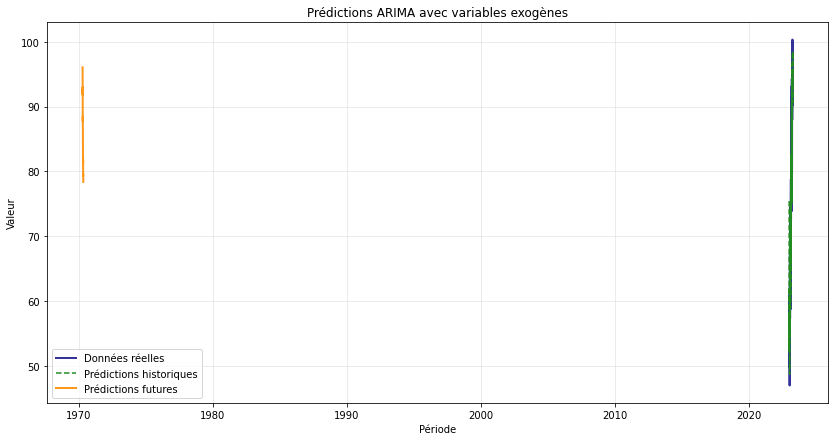

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')

def MakePredictionARIMA(train_data, model, X_future, target_col=None, 
                        figsize=(12, 6), train_color='blue', 
                        forecast_color='red', history_color='green'):
    """
    Effectue des prédictions rétrospectives sur l'historique et des prédictions 
    sur de nouveaux points avec un modèle ARIMA avec variables exogènes.
    
    Parameters:
    -----------
    train_data : pandas DataFrame
        Données historiques d'entraînement contenant la série cible et les variables exogènes
    model : ARIMA model
        Modèle ARIMA entraîné avec variables exogènes
    X_future : pandas DataFrame
        Nouvelles données exogènes pour les prédictions futures
    target_col : str, optional
        Nom de la colonne cible. Si None, on suppose que c'est la première colonne
    figsize : tuple, optional
        Dimensions de la figure
    train_color : str, optional
        Couleur pour les données réelles d'entraînement
    forecast_color : str, optional
        Couleur pour les prédictions futures
    history_color : str, optional
        Couleur pour les prédictions rétrospectives
    
    Returns:
    --------
    tuple : (predictions_historique, predictions_futures, figure)
    """
    
    # Identifier la colonne cible
    if target_col is None:
        # On suppose que la première colonne est la cible
        y_train = train_data.iloc[:, 0]
        X_train = train_data.iloc[:, 1:]
    else:
        y_train = train_data[target_col]
        X_train = train_data.drop(columns=[target_col])
    
    # Vérifier que les dimensions sont compatibles
    if len(X_train.columns) != len(X_future.columns):
        raise ValueError(f"Nombre de variables exogènes incompatible: "
                         f"entraînement={len(X_train.columns)}, "
                         f"futur={len(X_future.columns)}")
    
    # 1. Prédictions rétrospectives sur l'historique
    history_predictions = model.predict(start=0, end=len(y_train)-1, 
                                        exog=X_train)
    
    # 2. Prédictions sur les nouveaux points
    future_predictions = model.forecast(steps=len(X_future), exog=X_future)
    
    # 3. Préparation des indices pour le graphique
    historical_index = y_train.index
    future_index = pd.RangeIndex(start=len(historical_index), 
                                 stop=len(historical_index) + len(X_future))
    
    # 4. Création du graphique
    fig, ax = plt.subplots(figsize=figsize)
    
    # Données réelles d'entraînement
    ax.plot(historical_index, y_train.values, color=train_color, 
            label='Données réelles', linewidth=2, alpha=0.8)
    
    # Prédictions rétrospectives
    ax.plot(historical_index, history_predictions.values, color=history_color, 
            label='Prédictions historiques', linestyle='--', linewidth=1.5)
    
    # Prédictions futures
    ax.plot(future_index, future_predictions.values, color=forecast_color, 
            label='Prédictions futures', linewidth=2, alpha=0.9)
    
    # Ligne verticale pour séparer historique et futur
    if len(historical_index) > 0:
        last_historical = historical_index[-1]
        if isinstance(last_historical, (int, np.integer)):
            ax.axvline(x=last_historical + 0.5, color='gray', 
                      linestyle=':', linewidth=1, alpha=0.7)
            ax.text(last_historical + 0.5, ax.get_ylim()[1]*0.95, 
                   'Prédiction future', ha='center', 
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.3))
    
    # Personnalisation du graphique
    ax.set_xlabel('Période')
    ax.set_ylabel('Valeur')
    ax.set_title('Prédictions ARIMA avec variables exogènes')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    
    # Ajuster les limites de l'axe x
    all_indices = list(historical_index) + list(future_index)
    ax.set_xlim(min(all_indices) - 1, max(all_indices) + 1)
    
    plt.tight_layout()
    
    return history_predictions, future_predictions, fig


# Exemple d'utilisation
# Exemple de données (à adapter selon votre cas)
np.random.seed(42)

# Création de données d'exemple
n_train = 100
n_future = 20

# Données d'entraînement
dates_train = pd.date_range(start='2023-01-01', periods=n_train, freq='D')
y_train = 50 + 0.5 * np.arange(n_train) + np.random.randn(n_train) * 5
X1_train = np.random.randn(n_train) * 2 + 0.1 * np.arange(n_train)
X2_train = np.random.randn(n_train) * 3

train_df = pd.DataFrame({
   'target': y_train,
   'exog1': X1_train,
   'exog2': X2_train
}, index=dates_train)

# Données futures (variables exogènes seulement)
dates_future = pd.date_range(start=dates_train[-1] + pd.Timedelta(days=1), 
                           periods=n_future, freq='D')
X1_future = np.random.randn(n_future) * 2 + 0.1 * np.arange(n_train, n_train + n_future)
X2_future = np.random.randn(n_future) * 3

future_df = pd.DataFrame({
   'exog1': X1_future,
   'exog2': X2_future
}, index=dates_future)

# Entraînement d'un modèle ARIMA (exemple)
try:
   # Note: Dans la pratique, vous entraîneriez votre modèle séparément
   model = ARIMA(train_df['target'], exog=train_df[['exog1', 'exog2']], 
                  order=(1, 0, 0))
   fitted_model = model.fit()
   
   # Utilisation de la fonction
   hist_pred, fut_pred, fig = MakePredictionARIMA(
      train_data=train_df,
      model=fitted_model,
      X_future=future_df,
      target_col='target',
      figsize=(14, 7),
      train_color='navy',
      forecast_color='darkorange',
      history_color='forestgreen'
   )
   
   plt.show()
   
   # Affichage des résultats
   print("Prédictions historiques (5 premières):")
   print(hist_pred.head())
   print("\nPrédictions futures (5 premières):")
   print(fut_pred.head())
   
except Exception as e:
   print(f"Erreur lors de l'exemple: {e}")
   print("Création d'un exemple simplifié...")
   
   # Exemple plus simple sans entraînement réel du modèle
   print("\nLa fonction est prête à être utilisée avec votre modèle ARIMA entraîné.")

In [7]:
hist_pred

NameError: name 'hist_pred' is not defined